# Baseline model - based on [this](https://drivendata.co/blog/hateful-memes-benchmark/)

In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
data_dir = Path.cwd().parent / "data" / "hateful_memes"

img_path = data_dir / "img"
train_path = data_dir / "train.jsonl"
dev_path = data_dir / "dev_seen.jsonl"
test_path = data_dir / "test_seen.jsonl"

In [3]:
train_samples_frame = pd.read_json(train_path, lines=True)
train_samples_frame.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [4]:
train_samples_frame.label.value_counts()

label
0    5481
1    3019
Name: count, dtype: int64

## Exploring the data

In [5]:
train_samples_frame.text.map(
    lambda text: len(text.split(" "))
).describe()

count    8500.000000
mean       11.748706
std         6.877880
min         1.000000
25%         7.000000
50%        10.000000
75%        15.000000
max        70.000000
Name: text, dtype: float64

In [6]:
from PIL import Image


images = [
    Image.open(
        data_dir / train_samples_frame.loc[i, "img"]
    ).convert("RGB")
    for i in range(5)
]

for image in images:
    print(image.size)

(265, 400)
(800, 533)
(558, 800)
(693, 800)
(550, 416)


In [7]:
import torch
import torchvision

o:\memes_analysis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


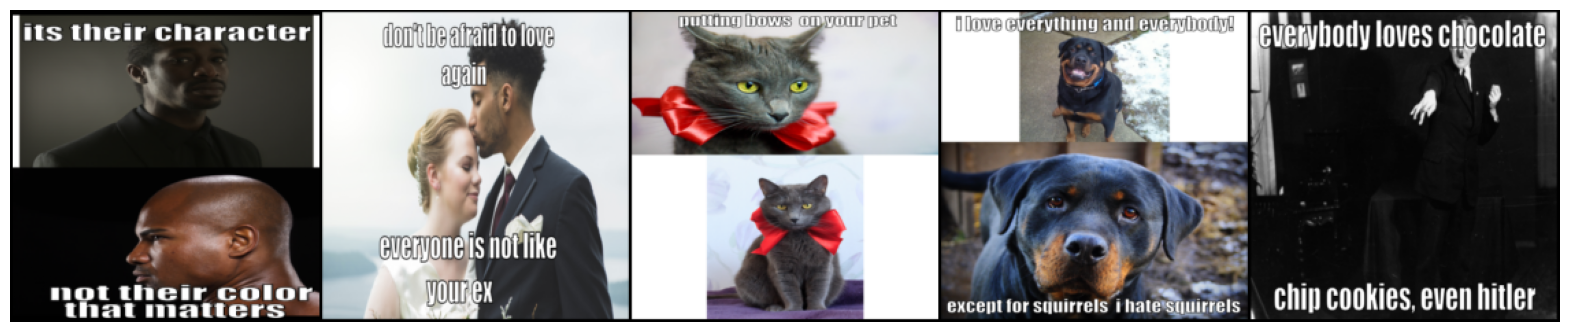

In [8]:
image_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size=(224, 224)),
        torchvision.transforms.ToTensor()
    ]
)

tensor_img = torch.stack(
    [image_transform(image) for image in images]
)
grid = torchvision.utils.make_grid(tensor_img)

plt.rcParams["figure.figsize"] = (20, 5)
plt.axis('off')
_ = plt.imshow(grid.permute(1, 2, 0))

### Dataset

In [9]:
class HatefulMemesDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        data_path,
        img_dir,
        image_transform,
        text_transform,
        balance=False,
        dev_limit=None,
        random_state=0,
    ):

        self.samples_frame = pd.read_json(data_path, lines=True)
        self.dev_limit = dev_limit

        if balance:
            neg = self.samples_frame[
                self.samples_frame.label.eq(0)
            ]
            pos = self.samples_frame[
                self.samples_frame.label.eq(1)
            ]
            self.samples_frame = pd.concat(
                [
                    neg.sample(
                        pos.shape[0],
                        random_state=random_state
                    ),
                    pos
                ]
            )

        if self.dev_limit:
            if self.samples_frame.shape[0] > self.dev_limit:
                self.samples_frame = self.samples_frame.sample(
                    dev_limit, random_state=random_state
                )
        self.samples_frame = self.samples_frame.reset_index(
            drop=True
        )
        self.samples_frame.img = self.samples_frame.apply(
            lambda row: (img_dir / row.img), axis=1
        )

        # https://github.com/drivendataorg/pandas-path
        # if not self.samples_frame.img.path.exists().all():
            # raise FileNotFoundError
        # if not self.samples_frame.img.path.is_file().all():
            # raise TypeError

        self.image_transform = image_transform
        self.text_transform = text_transform

    def __len__(self):
        """This method is called when you do len(instance)
        for an instance of this class.
        """
        return len(self.samples_frame)

    def __getitem__(self, idx):
        """This method is called when you do instance[key]
        for an instance of this class.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.samples_frame.loc[idx, "id"]

        image = Image.open(
            self.samples_frame.loc[idx, "img"]
        ).convert("RGB")
        image = self.image_transform(image)

        text = torch.Tensor(
            self.text_transform.get_sentence_vector(
                self.samples_frame.loc[idx, "text"]
            )
        ).squeeze()

        if "label" in self.samples_frame.columns:
            label = torch.Tensor(
                [self.samples_frame.loc[idx, "label"]]
            ).long().squeeze()
            sample = {
                "id": img_id,
                "image": image,
                "text": text,
                "label": label
            }
        else:
            sample = {
                "id": img_id,
                "image": image,
                "text": text
            }

        return sample

## Model

In [10]:
class LanguageAndVisionConcat(torch.nn.Module):
    def __init__(
        self,
        num_classes,
        loss_fn,
        language_module,
        vision_module,
        language_feature_dim,
        vision_feature_dim,
        fusion_output_size,
        dropout_p,

    ):
        super(LanguageAndVisionConcat, self).__init__()
        self.language_module = language_module
        self.vision_module = vision_module
        self.fusion = torch.nn.Linear(
            in_features=(language_feature_dim + vision_feature_dim),
            out_features=fusion_output_size
        )
        self.fc = torch.nn.Linear(
            in_features=fusion_output_size,
            out_features=num_classes
        )
        self.loss_fn = loss_fn
        self.dropout = torch.nn.Dropout(dropout_p)

    def forward(self, text, image, label=None):
        text_features = torch.nn.functional.relu(
            self.language_module(text)
        )
        image_features = torch.nn.functional.relu(
            self.vision_module(image)
        )
        combined = torch.cat(
            [text_features, image_features], dim=1
        )
        fused = self.dropout(
            torch.nn.functional.relu(
            self.fusion(combined)
            )
        )
        logits = self.fc(fused)
        pred = torch.nn.functional.softmax(logits)
        loss = (
            self.loss_fn(pred, label)
            if label is not None else label
        )
        return (pred, loss)

In [11]:
from torch import nn

class HatefulMemesModel(nn.Module):
    def __init__(self, hparams):
        super(HatefulMemesModel, self).__init__()

        for data_key in ["train_path", "dev_path", "img_dir",]:
            # ok, there's one for-loop but it doesn't count
            if data_key not in hparams.keys():
                raise KeyError(
                    f"{data_key} is a required hparam in this model"
                )

        self.hparams = hparams

        self.embedding_dim = self.hparams.get("embedding_dim", 300)
        self.language_feature_dim = self.hparams.get("language_feature_dim", 300)
        self.vision_feature_dim = self.hparams.get("vision_feature_dim", self.language_feature_dim)
        self.output_path = Path(self.hparams.get("output_path", "model-outputs"))

        self.model = self._build_model()

    def forward(self, text, image, label=None):
        return self.model(text, image, label)

    def _build_model(self):
        # we're going to pass the outputs of our text
        # transform through an additional trainable layer
        # rather than fine-tuning the transform
        language_module = torch.nn.Linear(
                in_features=self.embedding_dim,
                out_features=self.language_feature_dim
        )

        # easiest way to get features rather than
        # classification is to overwrite last layer
        # with an identity transformation, we'll reduce
        # dimension using a Linear layer, resnet is 2048 out
        vision_module = torchvision.models.resnet152(
            pretrained=True
        )
        vision_module.fc = torch.nn.Linear(
                in_features=2048,
                out_features=self.vision_feature_dim
        )

        return LanguageAndVisionConcat(
            num_classes=self.hparams.get("num_classes", 2),
            loss_fn=torch.nn.CrossEntropyLoss(),
            language_module=language_module,
            vision_module=vision_module,
            language_feature_dim=self.language_feature_dim,
            vision_feature_dim=self.vision_feature_dim,
            fusion_output_size=self.hparams.get(
                "fusion_output_size", 512
            ),
            dropout_p=self.hparams.get("dropout_p", 0.1),
        )

## Training the model

In [12]:
hparams = {
    "train_path": train_path,
    "dev_path": dev_path,
    "img_dir": data_dir,

    "embedding_dim": 150,
    "language_feature_dim": 300,
    "vision_feature_dim": 300,
    "fusion_output_size": 256,
    "output_path": "model-outputs",
    "dev_limit": None,
    "lr": 0.00005,
    "max_epochs": 10,
    "n_gpu": 1,
    "batch_size": 4,
    "accumulate_grad_batches": 16,
    "early_stop_patience": 3,
}

In [13]:
image_dim = hparams.get("image_dim", 224)

image_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(
                    size=(image_dim, image_dim)
                ),
                torchvision.transforms.ToTensor(),
                # all torchvision models expect the same
                # normalization mean and std
                # https://pytorch.org/docs/stable/torchvision/models.html
                torchvision.transforms.Normalize(
                    mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)
                ),
            ]
        )

import fasttext

with open('train_prepared.txt', 'w', encoding='utf-8') as f:
    for i in range(len(train_samples_frame)):
        f.write(train_samples_frame.loc[i, "text"] + '\n')

text_transform = fasttext.train_unsupervised(
    'train_prepared.txt',
    model=hparams.get("fasttext_model", "cbow"),
    dim=hparams.get("embedding_dim", 224)
)


train_dataset = HatefulMemesDataset(
            data_path=train_path,
            img_dir=data_dir,
            image_transform=image_transform,
            text_transform=text_transform,
            dev_limit=(
                hparams.get("dev_limit", None)
            ),
            balance=True
    )

dev_dataset = HatefulMemesDataset(
            data_path=dev_path,
            img_dir=data_dir,
            image_transform=image_transform,
            text_transform=text_transform,
            dev_limit=None,
            balance=False
    )

test_dataset = HatefulMemesDataset(
            data_path=test_path,
            img_dir=data_dir,
            image_transform=image_transform,
            text_transform=text_transform,
            dev_limit=None,
            balance=False
    )

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=hparams.get("batch_size", 4), shuffle=True, num_workers=hparams.get("num_workers", 16))
dev_loader = DataLoader(dev_dataset, batch_size=hparams.get("batch_size", 4), shuffle=False, num_workers=hparams.get("num_workers", 16))

o:\memes_analysis\venv\Lib\site-packages\torch\utils\data\dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
num_epochs = hparams.get("max_epochs", 100)

In [16]:
import torch.optim as optim

model = HatefulMemesModel(hparams)
optimizer = optim.AdamW(model.parameters(), lr=hparams.get("lr", 0.001))
loss_fn = torch.nn.CrossEntropyLoss()

o:\memes_analysis\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
o:\memes_analysis\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
for epoch in range(num_epochs):
    print('before train')
    model.train()
    print('after')

    total_loss = 0.0
    num_batches = 0

    print('przed tqdm')
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        optimizer.zero_grad()

        text, image, label = batch
        preds = model(text, image)

        # Calculate the loss
        loss = loss_fn(preds, label)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update loss and batch count
        total_loss += loss.item()
        num_batches += 1

    # Calculate average training loss for the epoch
    avg_train_loss = total_loss / num_batches

    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track validation loss
    total_val_loss = 0.0
    num_val_batches = 0

    # Iterate through the validation data
    with torch.no_grad():
        for val_batch in tqdm(dev_loader, desc=f"Validation - Epoch {epoch + 1}/{num_epochs}"):
            # Forward pass
            text, image, label = val_batch
            val_preds = model(text, image)

            # Calculate the validation loss
            val_loss = loss_fn(val_preds, label)

            # Update validation loss and batch count
            total_val_loss += val_loss.item()
            num_val_batches += 1

    # Calculate average validation loss for the epoch
    avg_val_loss = total_val_loss / num_val_batches

    # Print training and validation loss for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}: "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}")

before train
after
przed tqdm


Epoch 1/10:   0%|          | 0/1510 [00:00<?, ?it/s]o:\memes_analysis\venv\Lib\site-packages\torch\utils\data\dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
